# Fine-tuning on Pre-trained Model for Multiomic Integration
In this tutorial, we demonstrate how to fine-tune a pre-trained model for multiomic integration. We use the BMMC dataset as an example for RNA and protein abundance data integration from CITE-seq. The BMMC dataset consists of multiple batches by donor origin. In the paired integration setting, each cell contains both RNA and protein measurements. We fine-tune on the pre-trained whole-body model.

We summarize the fine-tuning pipeline in the following steps, which can be used as a general recipe for finetuning on integration tasks and beyond: 

     1. Specify hyper-parameter setup for integration task
     
     2. Load and pre-process data
     
     3. Load the pre-trained scGPT model
     
     4. Finetune scGPT with task-specific objectives
     
     5. Evaluate fine-tuned scGPT

In [1]:
import copy
import gc
import json
import os
from pathlib import Path
import sys
import time
import traceback
#from typing import List, Tuple, Dict, Union, Optional
import warnings

import torch
from anndata import AnnData
import anndata
import scanpy as sc
# import scvi
import numpy as np
import wandb
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)
import pandas as pd
import scipy.sparse as sp
from sklearn import preprocessing

sys.path.insert(0, "../")
from scgpt import prepare_data, prepare_dataloader, define_wandb_metrcis, evaluate, eval_testdata, train, eval_testdata_save_embed
from scgpt.tokenizer import tokenize_and_pad_batch
from scgpt.model import MultiOmicTransformerModel

import scgpt as scg
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.tokenizer import random_mask_value
from scgpt.loss import (
    masked_mse_loss,
    masked_relative_error,
    criterion_neg_log_bernoulli,
)
from scgpt.preprocess import Preprocessor
from scgpt.utils import set_seed, category_str2int, eval_scib_metrics

sc.set_figure_params(figsize=(4, 4))
os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/scanpy/_settings.py:450: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


## Step1: Specify hyper-parameter setup for integration task
Here we provide some hyper-parameter recommendations for the multiomic integration task. Note that the BMMC dataset contains multiple batches to be integrated. Therefore, in addition to the default gene modelling objectives, we also turn on DAR objectives specifically to faciliate batch integration. We also turn on the use_mod argument as default to ensure that the model is modality-aware during training.

In [2]:
hyperparameter_defaults = dict(
    task = 'multiomic',
    seed=42,
    dataset_name='SCMBench', # Dataset name "BMMC"
    do_train=True, # Flag to indicate whether to do update model parameters during training
    load_model="../save/scGPT_human", # Path to pre-trained model
    freeze = False, #freeze
    GEP=True, # Gene expression modelling
    GEPC=True, # Gene expression modelling for cell objective
    CLS=False,
    ESC=False,
    DAR = True, # DAR objective weight for batch correction
    DSBN = False,  # Domain-spec batchnorm,
    mask_ratio=0.4, # Default mask ratio
    explicit_zero_prob = False,  # whether explicit bernoulli for zeros
    ecs_thres=0,  # Elastic cell similarity objective, 0.0 to 1.0, 0.0 to disable
    dab_weight=1.0,
    use_batch_labels = True,
    use_mod = True,
    per_seq_batch_sample = False,
    epochs=25, # Default number of epochs for fine-tuning #25
    input_layer_key = "X_binned", # Default expression value binning in data pre-processing
    n_bins=51, # Default number of bins for value binning in data pre-processing
    n_hvg = 1200,  # Default number of highly variable genes
    n_hvp = 4000,
    max_seq_len = 4001, # # Default n_hvg+1
    lr=1e-3, # Default learning rate for fine-tuning
    batch_size=16, # Default batch size for fine-tuning
    layer_size=512,
    nlayers=4,
    nhead=8, # if load model, batch_size, layer_size, nlayers, nhead will be ignored
    dropout=0.2, # Default dropout rate during model fine-tuning
    schedule_ratio=0.95,  # Default rate for learning rate decay
    save_eval_interval=5, # Default model evaluation interval
    log_interval=100, # Default log interval
    fast_transformer=True, # Default setting
    pre_norm=False, # Default setting
    amp=True,  # Default setting: Automatic Mixed Precision
    pad_token = "<pad>",
    mask_value = -1,
    pad_value = -2,
    include_zero_gene = False,
)

In [3]:
run = wandb.init(
    config=hyperparameter_defaults,
    project="scGPT",
    reinit=True,
    settings=wandb.Settings(start_method="fork"),
)
config = wandb.config
print(config)

set_seed(config.seed)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


{'task': 'multiomic', 'seed': 42, 'dataset_name': 'SCMBench', 'do_train': True, 'load_model': '../save/scGPT_human', 'freeze': False, 'GEP': True, 'GEPC': True, 'CLS': False, 'ESC': False, 'DAR': True, 'DSBN': False, 'mask_ratio': 0.4, 'explicit_zero_prob': False, 'ecs_thres': 0, 'dab_weight': 1.0, 'use_batch_labels': True, 'use_mod': True, 'per_seq_batch_sample': False, 'epochs': 25, 'input_layer_key': 'X_binned', 'n_bins': 51, 'n_hvg': 1200, 'n_hvp': 4000, 'max_seq_len': 4001, 'lr': 0.001, 'batch_size': 16, 'layer_size': 512, 'nlayers': 4, 'nhead': 8, 'dropout': 0.2, 'schedule_ratio': 0.95, 'save_eval_interval': 5, 'log_interval': 100, 'fast_transformer': True, 'pre_norm': False, 'amp': True, 'pad_token': '<pad>', 'mask_value': -1, 'pad_value': -2, 'include_zero_gene': False}


In [4]:
# settings for input and preprocessing
special_tokens = [config.pad_token, "<cls>", "<eoc>"]

In [5]:
dataset_name = config.dataset_name
save_dir = Path(f"./save/dev_{dataset_name}-{time.strftime('%b%d-%H-%M')}/")
save_dir.mkdir(parents=True, exist_ok=True)
print(f"save to {save_dir}")
logger = scg.logger
scg.utils.add_file_handler(logger, save_dir / "run.log")

save to save/dev_SCMBench-Mar28-01-56


## Step 2: Load and pre-process data

### 2.1 Load the BMMC data
Please download the data from https://drive.google.com/file/d/10RxboePS5p2Jj2Sfq1Ghzgqnl6nqPv5V/view?usp=sharing

For the purpose of this tutorial, we selected a 12K+ cell subset from the BMMC dataset (originally 90K+ cells) to speed up training. More specifically, we filtered on the first 3 donors (batches) with B, Mono and T cell subtypes as shown in the data loading step below.

In [6]:
# dataset_dir_name='10x-Multiome-Pbmc10k-small'
dataset_dir_name='Chen-2019-small'
# dataset_dir_name='Ma-2020-batch-56-small'
# dataset_dir_name='Ma-2020-sampled-small'
input_rna_dir='/mnt/nas/user/yixuan/Multiomics-benchmark-main/data/download/'+dataset_dir_name+'/'+dataset_dir_name+'-RNA.h5ad'
input_atac_dir='/mnt/nas/user/yixuan/Multiomics-benchmark-main/data/download/'+dataset_dir_name+'/'+dataset_dir_name+'-ATAC.h5ad'

output_rna_dir='/mnt/nas/user/yixuan/Multiomics-benchmark-main/evaluation/workflow/scripts/scGPT-output/'+dataset_dir_name+'/'+dataset_dir_name+'-rna.csv'
output_atac_dir='/mnt/nas/user/yixuan/Multiomics-benchmark-main/evaluation/workflow/scripts/scGPT-output/'+dataset_dir_name+'/'+dataset_dir_name+'-atac.csv'

In [7]:
print(input_rna_dir)
print(output_rna_dir)

/mnt/nas/user/yixuan/Multiomics-benchmark-main/data/download/Chen-2019-small/Chen-2019-small-RNA.h5ad
/mnt/nas/user/yixuan/Multiomics-benchmark-main/evaluation/workflow/scripts/scGPT-output/Chen-2019-small/Chen-2019-small-rna.csv


In [8]:
if dataset_name == 'BMMC':
    adata = sc.read('scmdata/BMMC_processed.h5ad')
    # subset to first 3 donors with B, Mono and T cell subtypes
    adata = adata[adata.obs.DonorID.isin([10886, 11466, 12710]) & adata.obs.cell_type.isin(np.unique(adata.obs.cell_type.values)[:17])]
    adata.obs["celltype"] = adata.obs["cell_type"].astype(str).astype('category')
    adata.var["gene_name"] = adata.var.index.tolist()
    le = preprocessing.LabelEncoder()
    encoded_batch = le.fit_transform(adata.obs['batch'].values)
    adata.obs["batch_id"] =  encoded_batch
    adata.obs["str_batch"] = adata.obs["batch_id"].astype('category')
    adata_protein = adata[:, adata.var.feature_types.isin(['ADT'])].copy()
    adata_protein.var.index = ['p_' + i for i in adata_protein.var.index]
    adata = adata[:, adata.var.feature_types.isin(['GEX'])].copy()
    data_is_raw = False
if dataset_name == 'SCMBench':
    adata = anndata.read_h5ad(input_rna_dir)
    adata_protein = anndata.read_h5ad(input_atac_dir)
    adata.obs["celltype"] = adata.obs["cell_type"].astype(str).astype('category')
    adata.var["gene_name"] = adata.var.index.tolist()
    le = preprocessing.LabelEncoder()
    encoded_batch = le.fit_transform(adata.obs['domain'].values)
    adata.obs["batch_id"] =  encoded_batch
    adata.obs["str_batch"] = adata.obs["batch_id"].astype('category')
    data_is_raw = False
    print('#')

#


In [9]:
adata.obs

,domain,protocol,dataset,cell_type,celltype,batch_id,str_batch
cells,,,,,,,
09A_CAGCCCCGCCTT,scRNA-seq,SNARE-seq,Chen-2019-RNA,E3Rorb,E3Rorb,0,0
09A_CGCCTACCATGA,scRNA-seq,SNARE-seq,Chen-2019-RNA,E5Parm1,E5Parm1,0,0
09A_GATGCGCGGCTA,scRNA-seq,SNARE-seq,Chen-2019-RNA,Ast,Ast,0,0
09A_GGTCCGAGTCCT,scRNA-seq,SNARE-seq,Chen-2019-RNA,E4Il1rapl2,E4Il1rapl2,0,0
09A_TCTCCCGGCACC,scRNA-seq,SNARE-seq,Chen-2019-RNA,E5Parm1,E5Parm1,0,0
...,...,...,...,...,...,...,...
09L_CTGTACCTGGTC,scRNA-seq,SNARE-seq,Chen-2019-RNA,Mic,Mic,0,0
09L_GGATTGTGGTTC,scRNA-seq,SNARE-seq,Chen-2019-RNA,Clau,Clau,0,0
09L_AGCGCAGGCATG,scRNA-seq,SNARE-seq,Chen-2019-RNA,E6Tle4,E6Tle4,0,0


In [10]:
if config.use_mod:
    gene_rna_df = pd.DataFrame(index = adata.var.index.tolist())
    gene_rna_df['mod'] = 'RNA'
    gene_protein_df = pd.DataFrame(index = adata_protein.var.index.tolist())
    gene_protein_df['mod'] = 'Protein'
    gene_loc_df = pd.concat([gene_rna_df, gene_protein_df])
    gene_loc_df['mod'] = gene_loc_df['mod'].astype('category')

### 2.2 Cross-check gene set with the pre-trained model 
Note that we retain the common gene set between the data and the pre-trained model for further fine-tuning.

In [11]:
if config.load_model is not None:
    model_dir = Path(config.load_model)
    model_config_file = model_dir / "args.json"
    model_file = model_dir / "best_model.pt"
    vocab_file = model_dir / "vocab.json"

    vocab = GeneVocab.from_file(vocab_file)
    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)

    adata.var["id_in_vocab"] = [
        1 if gene in vocab else -1 for gene in adata.var["gene_name"]
    ]
    gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
    logger.info(
        f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
        f"in vocabulary of size {len(vocab)}."
    )
    old_vocab = vocab
embsize = config.layer_size
nhead = config.nhead
nlayers = config.nlayers
d_hid = config.layer_size

scGPT - INFO - match 4/8000 genes in vocabulary of size 60697.


### 2.3 Pre-process the data
We follow the standardized pipline of depth normalization, log normalization, and highly vairable gene (HVG) selection for data pre-processing. We further introduce value binning to obtain the relative expressions of each HVG. Given multiple sequencing modalities, we perform the pre-processing steps on each individual modality first, and then combine them into multi-modal sequences as model input.

#### 2.3.1 Pre-process the RNA data

In [12]:
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=1,  # step 1
    filter_cell_by_counts=1,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=False,  # 5. whether to subset the raw data to highly variable genes #config.n_hvg
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=config.n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor(adata, batch_key=None)

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Filtering cells by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Binning data ...


#### 2.3.2 Pre-process the Protein data

In [13]:
preprocessor_protein = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=0,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=False,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=False,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=False,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor=None,
    binning=config.n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor_protein(adata_protein, batch_key=None)

scGPT - INFO - Binning data ...


#### 2.3.3 Combine RNA, and Protein data

In [16]:
adata_protein

AnnData object with n_obs × n_vars = 9190 × 80000
    obs: 'domain', 'protocol', 'dataset', 'cell_type'
    var: 'chrom', 'chromStart', 'chromEnd', 'genome', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'
    obsm: 'bin_edges'
    layers: 'X_binned'

In [14]:
data_combined = np.concatenate([adata.layers["X_binned"], adata_protein.layers["X_binned"]], axis=1)
adata = AnnData(
    X=data_combined,
    obs=adata.obs,
    var=pd.DataFrame(index=adata.var_names.tolist() + adata_protein.var_names.tolist()),
    layers={"X_binned": data_combined,}
)
adata.var["gene_name"] = adata.var.index.tolist()

In [15]:
adata

AnnData object with n_obs × n_vars = 9190 × 88000
    obs: 'domain', 'protocol', 'dataset', 'cell_type', 'celltype', 'batch_id', 'str_batch', 'n_counts'
    var: 'gene_name'
    layers: 'X_binned'

In [17]:
if config.per_seq_batch_sample:
    # sort the adata by batch_id in advance
    adata_sorted = adata[adata.obs["batch_id"].argsort()].copy()

### 2.4 Tokenize the input data for model fine-tuning

In [18]:
all_counts = (
    adata.layers[config.input_layer_key].A
    if issparse(adata.layers[config.input_layer_key])
    else adata.layers[config.input_layer_key]
)
genes = adata.var["gene_name"].tolist()

celltypes_labels = adata.obs["cell_type"].tolist()  # make sure count from 0
num_types = len(set(celltypes_labels))
celltypes_labels = np.array(celltypes_labels)

batch_ids = adata.obs["batch_id"].tolist()
num_batch_types = len(set(batch_ids))
batch_ids = np.array(batch_ids)

In [19]:
if config.use_mod:
    mod_type = np.array([gene_loc_df.loc[g, 'mod'] for g in genes])
    vocab_mod = Vocab(VocabPybind(np.unique(gene_loc_df['mod']).tolist() + special_tokens, None))
    vocab_mod.set_default_index(vocab_mod["<pad>"])
    mod_type = np.array(vocab_mod(list(mod_type)), dtype=int)
    ntokens_mod = len(vocab_mod)

In [20]:
(
    train_data,
    valid_data,
    train_celltype_labels,
    valid_celltype_labels,
    train_batch_labels,
    valid_batch_labels,
) = train_test_split(
    all_counts, celltypes_labels, batch_ids, test_size=0.1, shuffle=True
)


In [21]:
num_of_non_zero_genes = [
    np.count_nonzero(train_data[i]) for i in range(train_data.shape[0])
]
print(f"max num of non_zero genes: {np.max(num_of_non_zero_genes)}")
print(f"min num of non_zero genes: {np.min(num_of_non_zero_genes)}")
print(f"average num of non_zero genes: {np.mean(num_of_non_zero_genes)}")
print(
    f"99% quantile num of non_zero genes: {np.quantile(num_of_non_zero_genes, 0.99)}"
)
print(f"max original values: {np.max(train_data)}")
print(
    f"average original non_zero values: {np.mean(train_data[np.nonzero(train_data)])}"
)
print(
    f"99% quantile original non_zero values: {np.quantile(train_data[np.nonzero(train_data)], 0.99)}"
)
print(f"num of celltypes: {num_types}")

max num of non_zero genes: 3400
min num of non_zero genes: 218
average num of non_zero genes: 1088.4712852133962
99% quantile num of non_zero genes: 2720.3
max original values: 50
average original non_zero values: 25.278260210829007
99% quantile original non_zero values: 49.0
num of celltypes: 22


In [22]:
if config.load_model is None:
    vocab = Vocab(VocabPybind(genes + special_tokens, None))
    vocab.set_default_index(vocab["<pad>"])
    gene_ids = np.array(vocab(genes), dtype=int)
else:
    pretrained_genes = [g for g in genes + special_tokens if g in old_vocab]
    new_genes = [g for g in genes + special_tokens if g not in old_vocab]
    gene_ids_pretrained = np.array(old_vocab(pretrained_genes), dtype=int)
    # https://discuss.pytorch.org/t/expand-an-existing-embedding-and-linear-layer-nan-loss-value/55670/2
    # Retrieve pretrained weights
    vocab = Vocab(VocabPybind(pretrained_genes + new_genes, None))
    vocab.set_default_index(vocab["<pad>"])
    gene_ids = np.array(vocab(genes), dtype=int)

In [23]:
tokenized_train = tokenize_and_pad_batch(
    train_data,
    gene_ids,
    max_len=config.max_seq_len,
    vocab=vocab,
    pad_token=config.pad_token,
    pad_value=config.pad_value,
    append_cls=True,  # append <cls> token at the beginning
    include_zero_gene=config.include_zero_gene,
    mod_type=mod_type if config.use_mod else None,
    vocab_mod=vocab_mod if config.use_mod else None,
)
tokenized_valid = tokenize_and_pad_batch(
    valid_data,
    gene_ids,
    max_len=config.max_seq_len,
    vocab=vocab,
    pad_token=config.pad_token,
    pad_value=config.pad_value,
    append_cls=True,
    include_zero_gene=config.include_zero_gene,
    mod_type=mod_type if config.use_mod else None,
    vocab_mod=vocab_mod if config.use_mod else None,
)
logger.info(
    f"train set number of samples: {tokenized_train['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_train['genes'].shape[1]}"
)
logger.info(
    f"valid set number of samples: {tokenized_valid['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_valid['genes'].shape[1]}"
)

scGPT - INFO - train set number of samples: 8271, 
	 feature length: 3401
scGPT - INFO - valid set number of samples: 919, 
	 feature length: 3396


## Step 3: Load the pre-trained scGPT model
Note that for multiomic integration, since the pre-trained model does not include the ATAC and protein tokens, we expand the embedding layer by adding these new tokens. We inherit only the gene embedding layer from the pre-trained model, and train rest of the model from scratch.

In [23]:
torch.cuda.is_available()

True

In [24]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_number = 0
if torch.cuda.is_available():
    device = torch.device(f"cuda:{device_number}")
else:
    device = torch.device("cpu")
model_dict = torch.load(model_file)
ntokens = len(vocab)  # size of vocabulary
model = MultiOmicTransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid, 
    nlayers,
    vocab=vocab,
    dropout=config.dropout,
    pad_token=config.pad_token,
    pad_value=config.pad_value,
    do_mvc=config.GEPC,
    do_dab=config.DAR,
    use_batch_labels=config.use_batch_labels,
    num_batch_labels=num_batch_types,
    domain_spec_batchnorm=config.DSBN,
    n_input_bins=config.n_bins,
    ecs_threshold=config.ecs_thres,
    explicit_zero_prob=config.explicit_zero_prob,
    use_fast_transformer=config.fast_transformer,
    pre_norm=config.pre_norm,
    use_mod=config.use_mod,
    ntokens_mod=ntokens_mod if config.use_mod else None,
    vocab_mod=vocab_mod if config.use_mod else None,
)

with torch.no_grad():
    pretrained_emb_weights = model_dict['encoder.embedding.weight'][gene_ids_pretrained, :]
    model.encoder.embedding.weight.data[:len(pretrained_genes), :] = pretrained_emb_weights
    model.encoder.enc_norm.weight.data = model_dict['encoder.enc_norm.weight']
ntokens = len(vocab)

model.to(device)
wandb.watch(model)
print(model)

MultiOmicTransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(88003, 512, padding_idx=11)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (batch_encoder): BatchLabelEncoder(
    (embedding): Embedding(1, 512)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (mod_encoder): BatchLabelEncoder(
    (embedding): Embedding(5, 512, padding_idx=2)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): FlashTransformerEncoderLayer(
        (self_attn): FlashMHA(
          (Wqkv): Linear(in_features=512, out_featu

In [25]:
if config.GEP and config.GEPC:
    criterion_gep_gepc = masked_mse_loss
if config.CLS:
    criterion_cls = nn.CrossEntropyLoss()
if config.DAR:
    criterion_dab = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=config.lr, eps=1e-4 if config.amp else 1e-8
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=config.schedule_ratio)
scaler = torch.cuda.amp.GradScaler(enabled=config.amp)

## Step 4: Finetune scGPT with task-specific objectives

random masking at epoch   1, ratio of masked values in train:  0.3997
scGPT - INFO - | epoch   1 | 100/334 batches | lr 0.00100 | ms/batch 166.06 | loss 9024.88 | gep 371.15 |gepc 8653.72 |dar  0.00 |
scGPT - INFO - | epoch   1 | 200/334 batches | lr 0.00100 | ms/batch 157.39 | loss 408.64 | gep 205.18 |gepc 203.45 |dar  0.00 |
scGPT - INFO - | epoch   1 | 300/334 batches | lr 0.00100 | ms/batch 155.47 | loss 406.40 | gep 204.22 |gepc 202.17 |dar  0.00 |
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch   1 | time: 55.01s | valid loss 205.9305 | 
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - Best model with score 205.9305
random masking at epoch   2, ratio of masked values in train:  0.3997
scGPT - INFO - | epoch   2 | 100/334 batches | lr 0.00095 | ms/batch 158.82 | loss 410.25 | gep 206.39 |gepc 203.87 |dar  0.00 |
scGPT - INFO

100%|██████████| 371/371 [01:03<00:00,  5.87it/s]


cell_embeddings (5927, 512)
NMI...
ARI...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Graph connectivity...


/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
S

scGPT - INFO -                                   0
NMI_cluster/label          0.017184
ARI_cluster/label          0.002455
ASW_label                  0.476900
ASW_label/batch                 NaN
PCR_batch                  0.000000
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                 0.173874
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
scGPT - INFO - Biological Conservation Metrics: 
ASW (cell-type): 0.4769, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: 0.0000, ASW (batch): nan, graph connectivity: 0.1739, graph iLISI: nan


/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
S

random masking at epoch   6, ratio of masked values in train:  0.3997
scGPT - INFO - | epoch   6 | 100/334 batches | lr 0.00077 | ms/batch 314.60 | loss 409.06 | gep 206.19 |gepc 202.87 |dar  0.00 |
scGPT - INFO - | epoch   6 | 200/334 batches | lr 0.00077 | ms/batch 317.43 | loss 404.77 | gep 203.93 |gepc 200.83 |dar  0.00 |
scGPT - INFO - | epoch   6 | 300/334 batches | lr 0.00077 | ms/batch 316.27 | loss 405.54 | gep 204.31 |gepc 201.23 |dar  0.00 |
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch   6 | time: 109.45s | valid loss 204.6663 | 
scGPT - INFO - -----------------------------------------------------------------------------------------
random masking at epoch   7, ratio of masked values in train:  0.3997
scGPT - INFO - | epoch   7 | 100/334 batches | lr 0.00074 | ms/batch 257.47 | loss 409.38 | gep 206.42 |gepc 202.96 |dar  0.00 |
scGPT - INFO - | epoch   7 | 200/334 batches | lr 0.00074 |

100%|██████████| 371/371 [01:03<00:00,  5.84it/s]


cell_embeddings (5927, 512)


/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
PC regression...
Graph connectivity...
scGPT - INFO -                                   0
NMI_cluster/label          0.017362
ARI_cluster/label          0.003200
ASW_label                  0.474077
ASW_label/batch                 NaN
PCR_batch                  0.758587
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                 0.169174
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
scGPT - INFO - Biological Conservation Metrics: 
ASW (cell-type): 0.4741, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: 0.7586, ASW (batch): nan, graph connectivity: 0.1692, graph iLISI: nan


/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
S

random masking at epoch  11, ratio of masked values in train:  0.3997
scGPT - INFO - | epoch  11 | 100/334 batches | lr 0.00060 | ms/batch 315.78 | loss 408.41 | gep 206.06 |gepc 202.35 |dar  0.00 |
scGPT - INFO - | epoch  11 | 200/334 batches | lr 0.00060 | ms/batch 317.95 | loss 404.64 | gep 204.10 |gepc 200.54 |dar  0.00 |
scGPT - INFO - | epoch  11 | 300/334 batches | lr 0.00060 | ms/batch 322.01 | loss 404.85 | gep 204.27 |gepc 200.59 |dar  0.00 |
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch  11 | time: 109.83s | valid loss 204.3143 | 
scGPT - INFO - -----------------------------------------------------------------------------------------
random masking at epoch  12, ratio of masked values in train:  0.3997
scGPT - INFO - | epoch  12 | 100/334 batches | lr 0.00057 | ms/batch 319.41 | loss 408.19 | gep 206.06 |gepc 202.13 |dar  0.00 |
scGPT - INFO - | epoch  12 | 200/334 batches | lr 0.00057 |

100%|██████████| 371/371 [00:44<00:00,  8.29it/s]
/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


cell_embeddings (5927, 512)
NMI...
ARI...
Silhouette score...
PC regression...
Graph connectivity...
scGPT - INFO -                                   0
NMI_cluster/label          0.070329
ARI_cluster/label          0.028849
ASW_label                  0.453841
ASW_label/batch                 NaN
PCR_batch                  0.562998
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                 0.392585
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
scGPT - INFO - Biological Conservation Metrics: 
ASW (cell-type): 0.4538, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: 0.5630, ASW (batch): nan, graph connectivity: 0.3926, graph iLISI: nan


/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
S

random masking at epoch  16, ratio of masked values in train:  0.3997
scGPT - INFO - | epoch  16 | 100/334 batches | lr 0.00046 | ms/batch 161.94 | loss 404.35 | gep 202.29 |gepc 202.07 |dar  0.00 |
scGPT - INFO - | epoch  16 | 200/334 batches | lr 0.00046 | ms/batch 154.15 | loss 400.68 | gep 200.41 |gepc 200.28 |dar  0.00 |
scGPT - INFO - | epoch  16 | 300/334 batches | lr 0.00046 | ms/batch 164.66 | loss 399.77 | gep 199.91 |gepc 199.86 |dar  0.00 |
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch  16 | time: 62.58s | valid loss 201.8414 | 
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - Best model with score 201.8414
random masking at epoch  17, ratio of masked values in train:  0.3997
scGPT - INFO - | epoch  17 | 100/334 batches | lr 0.00044 | ms/batch 222.44 | loss 404.08 | gep 202.10 |gepc 201.98 |dar  0.00 |
scGPT - INFO -

100%|██████████| 371/371 [01:00<00:00,  6.15it/s]
/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


cell_embeddings (5927, 512)
NMI...
ARI...
Silhouette score...
PC regression...
Graph connectivity...


/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


scGPT - INFO -                                   0
NMI_cluster/label          0.075349
ARI_cluster/label          0.024870
ASW_label                  0.440822
ASW_label/batch                 NaN
PCR_batch                  0.911957
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                 0.277152
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
scGPT - INFO - Biological Conservation Metrics: 
ASW (cell-type): 0.4408, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: 0.9120, ASW (batch): nan, graph connectivity: 0.2772, graph iLISI: nan


/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
S

random masking at epoch  21, ratio of masked values in train:  0.3997
scGPT - INFO - | epoch  21 | 100/334 batches | lr 0.00036 | ms/batch 304.74 | loss 402.64 | gep 201.33 |gepc 201.30 |dar  0.00 |
scGPT - INFO - | epoch  21 | 200/334 batches | lr 0.00036 | ms/batch 310.23 | loss 399.34 | gep 199.70 |gepc 199.64 |dar  0.00 |
scGPT - INFO - | epoch  21 | 300/334 batches | lr 0.00036 | ms/batch 305.83 | loss 400.20 | gep 200.13 |gepc 200.07 |dar  0.00 |
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch  21 | time: 105.12s | valid loss 202.2426 | 
scGPT - INFO - -----------------------------------------------------------------------------------------
random masking at epoch  22, ratio of masked values in train:  0.3997
scGPT - INFO - | epoch  22 | 100/334 batches | lr 0.00034 | ms/batch 162.38 | loss 403.24 | gep 201.67 |gepc 201.57 |dar  0.00 |
scGPT - INFO - | epoch  22 | 200/334 batches | lr 0.00034 |

MemoryError: Unable to allocate 3.89 GiB for an array with shape (5927, 88000) and data type int64

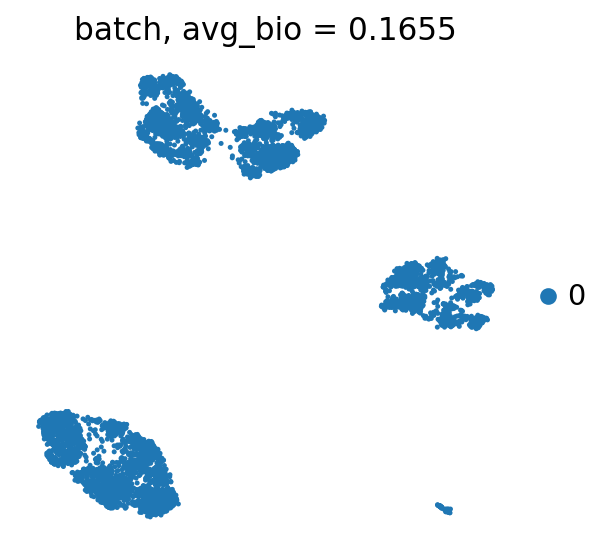

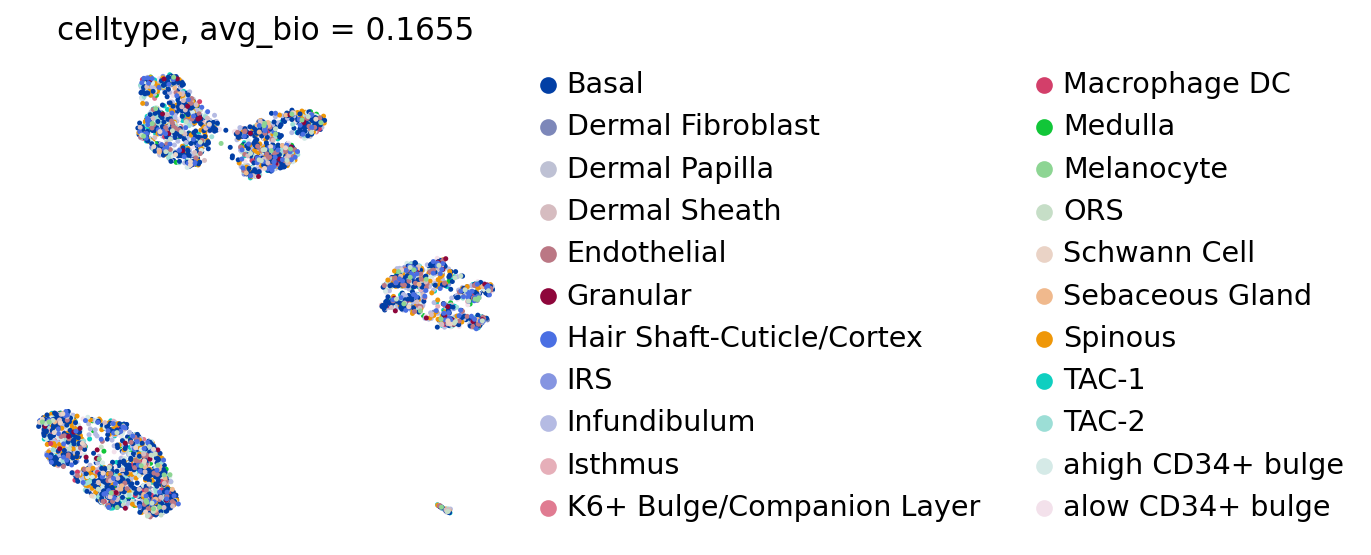

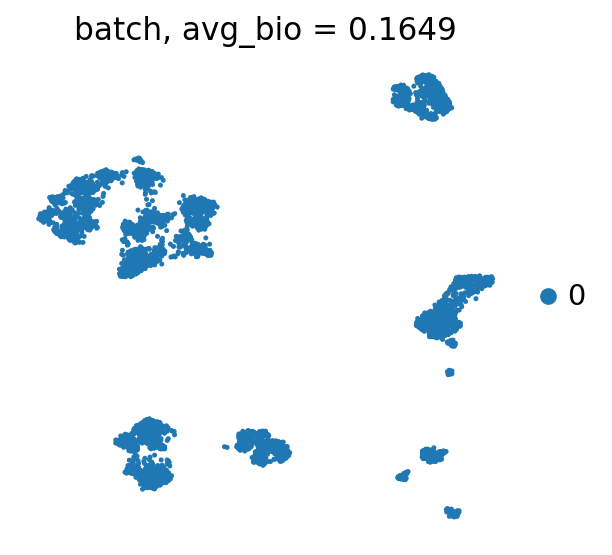

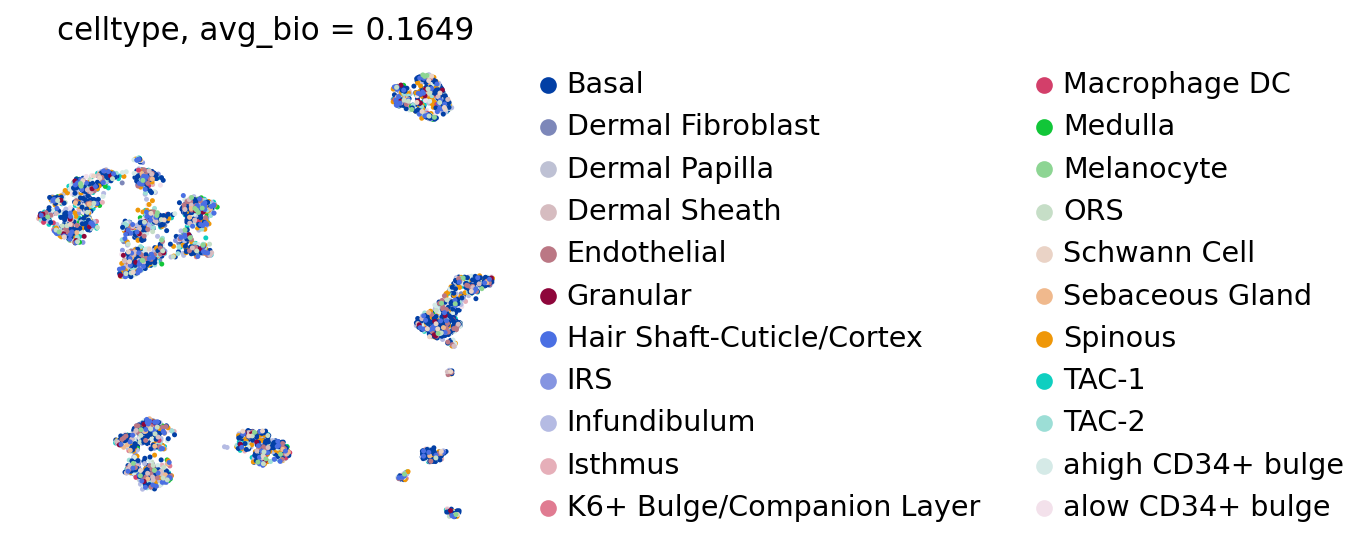

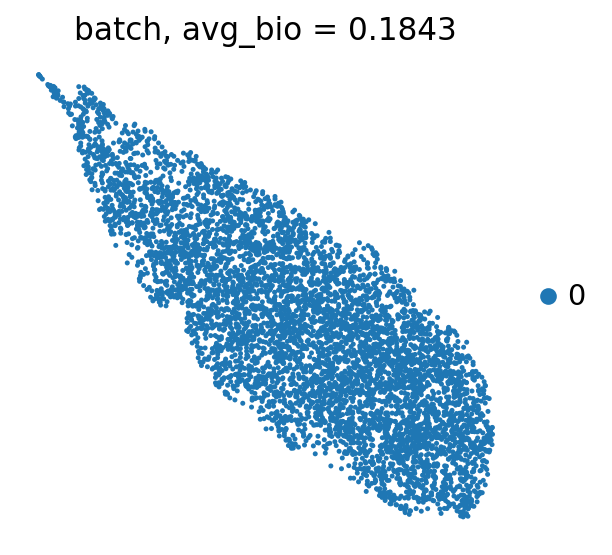

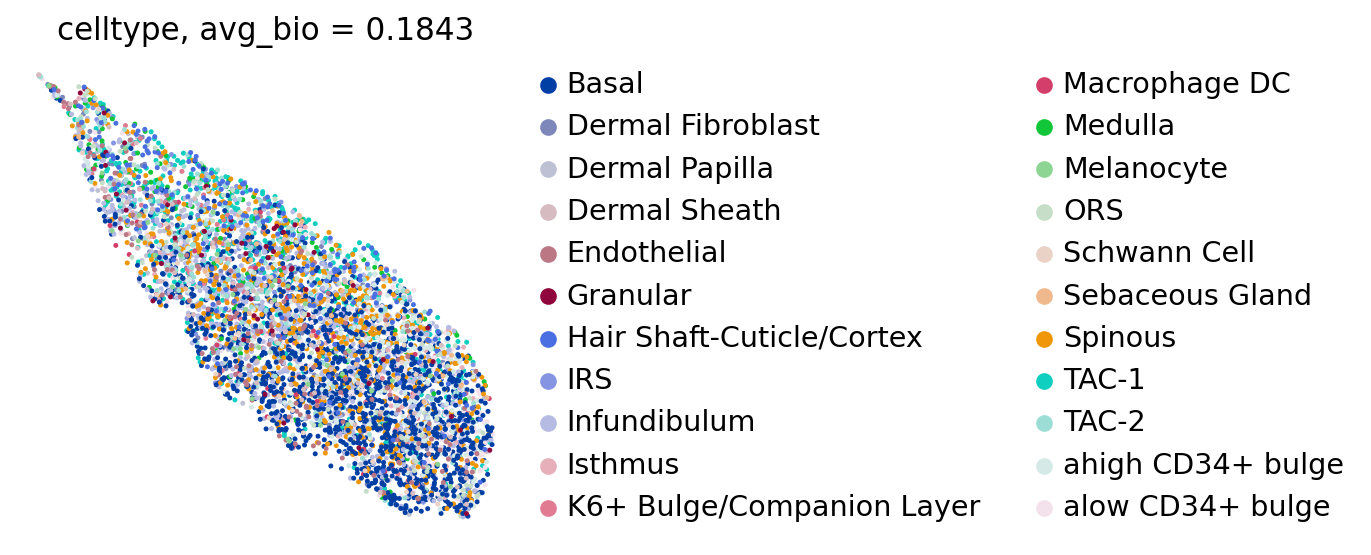

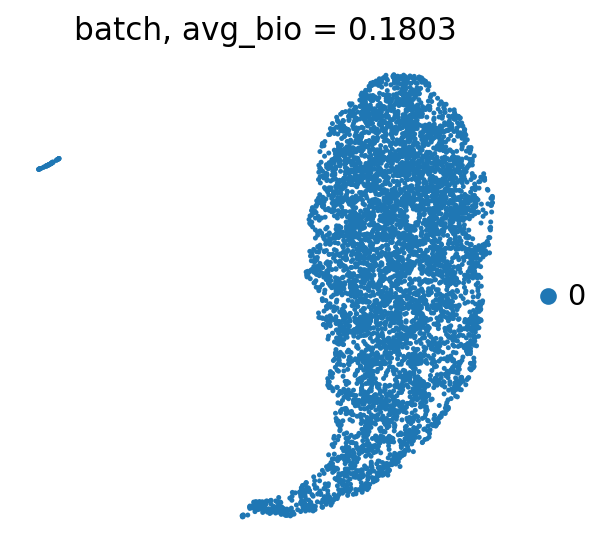

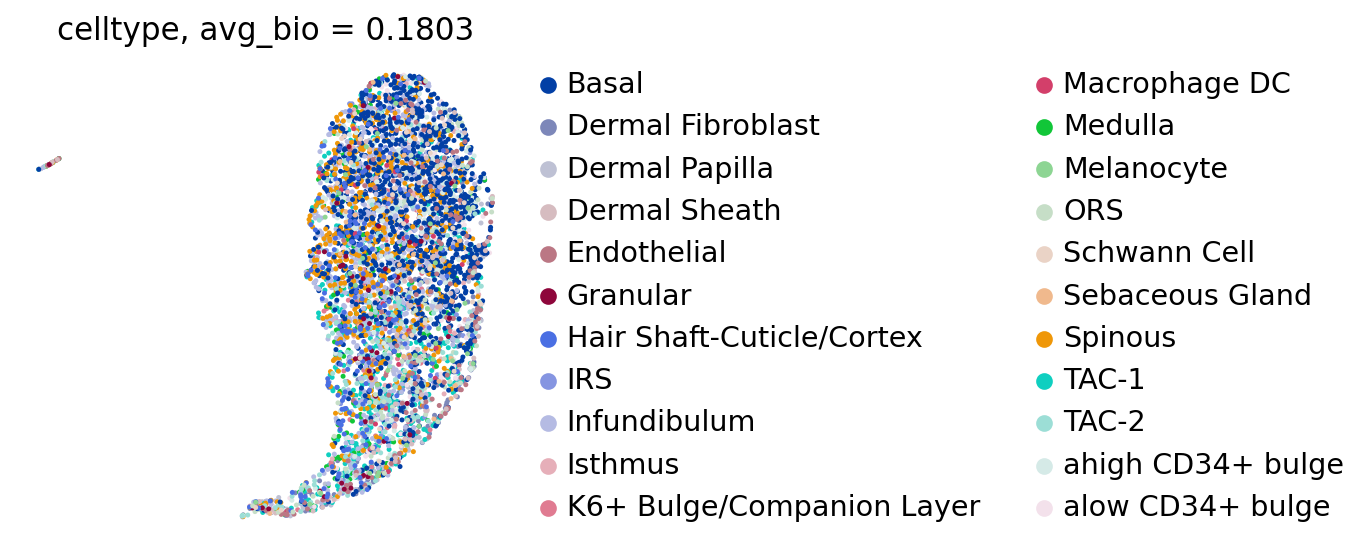

In [26]:
best_val_loss = float("inf")
best_avg_bio = 0.0
best_model = None
define_wandb_metrcis()

for epoch in range(1, config.epochs + 1):
    epoch_start_time = time.time()
    train_data_pt, valid_data_pt = prepare_data(
        tokenized_train=tokenized_train, 
        tokenized_valid=tokenized_valid, 
        train_batch_labels=train_batch_labels,
        valid_batch_labels=valid_batch_labels,
        config=config,
        epoch=epoch,
        sort_seq_batch=config.per_seq_batch_sample)
    
    train_loader = prepare_dataloader(
        train_data_pt,
        batch_size=config.batch_size,
        shuffle=True,
        intra_domain_shuffle=False,
        drop_last=False,
        per_seq_batch_sample=config.per_seq_batch_sample
    )
    valid_loader = prepare_dataloader(
        valid_data_pt,
        batch_size=config.batch_size,
        shuffle=False,
        intra_domain_shuffle=False,
        drop_last=False,
        per_seq_batch_sample=config.per_seq_batch_sample
    )

    if config.do_train:
        train(
            model=model,
            loader=train_loader,
            vocab=vocab,
            criterion_gep_gepc=criterion_gep_gepc if config.GEP and config.GEPC else None,
            criterion_dab=criterion_dab if config.DAR else None,
            criterion_cls=criterion_cls if config.CLS else None,
            scaler=scaler,
            optimizer=optimizer,
            scheduler=scheduler,
            device=device,
            config=config,
            logger=logger,
            epoch=epoch,
        )
    val_loss = evaluate(
        model=model,
        loader=valid_loader,
        vocab=vocab,
        criterion_gep_gepc=criterion_gep_gepc if config.GEP and config.GEPC else None,
        criterion_dab=criterion_dab if config.DAR else None,
        criterion_cls=criterion_cls if config.CLS else None,
        device=device,
        config=config,
        epoch=epoch
    )
    elapsed = time.time() - epoch_start_time
    logger.info("-" * 89)
    logger.info(
        f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | "
        f"valid loss {val_loss:5.4f} | "
    )
    logger.info("-" * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        best_model_epoch = epoch
        logger.info(f"Best model with score {best_val_loss:5.4f}")

    if epoch % config.save_eval_interval == 0 or epoch == config.epochs:
        logger.info(f"Saving model to {save_dir}")
        torch.save(best_model.state_dict(), save_dir / f"model_e{best_model_epoch}.pt")

        # eval on testdata
        # results = eval_testdata(
        #     model = best_model,
        #     adata_t = adata_sorted if config.per_seq_batch_sample else adata,
        #     gene_ids = gene_ids,
        #     vocab = vocab,
        #     config = config,
        #     logger = logger,
        #     include_types=["cls"],
        # )
        results,cell_embeddings = eval_testdata_save_embed(
            model = best_model,
            adata_t = adata_sorted if config.per_seq_batch_sample else adata,
            gene_ids = gene_ids,
            vocab = vocab,
            config = config,
            logger = logger,
            include_types=["cls"],
        )

        pd.DataFrame(cell_embeddings, index=adata.obs_names).to_csv(output_rna_dir, header=False)
        pd.DataFrame(cell_embeddings, index=adata.obs_names).to_csv(output_atac_dir, header=False)

        results["batch_umap"].savefig(
            save_dir / f"embeddings_batch_umap[cls]_e{best_model_epoch}.png", dpi=300
        )

        results["celltype_umap"].savefig(
            save_dir / f"embeddings_celltype_umap[cls]_e{best_model_epoch}.png", dpi=300
        )
        metrics_to_log = {"test/" + k: v for k, v in results.items()}
        metrics_to_log["test/batch_umap"] = wandb.Image(
            str(save_dir / f"embeddings_batch_umap[cls]_e{best_model_epoch}.png"),
            caption=f"celltype avg_bio epoch {best_model_epoch}",
        )

        metrics_to_log["test/celltype_umap"] = wandb.Image(
            str(save_dir / f"embeddings_celltype_umap[cls]_e{best_model_epoch}.png"),
            caption=f"celltype avg_bio epoch {best_model_epoch}",
        )
        metrics_to_log["test/best_model_epoch"] = best_model_epoch
        wandb.log(metrics_to_log)
        wandb.log({"avg_bio": results.get("avg_bio", 0.0)})

    scheduler.step()

In [ ]:
# save the best model
torch.save(best_model.state_dict(), save_dir / "best_model.pt")

In [ ]:
artifact = wandb.Artifact(f"best_model", type="model")
glob_str = os.path.join(save_dir, "best_model.pt")
artifact.add_file(glob_str)
run.log_artifact(artifact)

run.finish()
wandb.finish()
gc.collect()

/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
/mnt/nas/user/yixuan/miniconda3/envs/scGPT/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


avg_bio,▁█▂▂▂
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/ARI_cluster/label,▁██▇▇
test/ASW_label,█▃▁▁▁
test/NMI_cluster/label,▁▇███
test/PCR_batch,▂▁▁█▁
test/avg_bio,▁█▂▂▂
test/best_model_epoch,▁▅███
test/graph_conn,▁█▁▁▁
train/dab,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/gep,▇▅▇▄▅█▄▇▆█▅▄▅▄▄▄▅▄▄▄▆▁▄▃▅▃▃▃▃▃▂▄▄▄▄▅▃▂▂▂


98454